# Build Figure Dataset

Step 1 is to convert the image to an actual dataset that can be used for analysis.

Specifically we want the long format data used to generate the plot from the colorimetry image.

[source paper for the colorimetry figure](https://www.researchgate.net/figure/a-UV-vis-absorption-spectra-of-TMB-H2O2-Pt-CoSnOH6-colorimetric-system-composing-of_fig5_337149376)

# imports nb data and globals

In [163]:
# get the python version
import sys
print(sys.version)

3.10.6 (tags/v3.10.6:9c7b4bd, Aug  1 2022, 21:53:49) [MSC v.1932 64 bit (AMD64)]


In [164]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.signal import find_peaks
from sklearn.cluster import KMeans
import matplotlib.patches as patches
import pandas as pd
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess

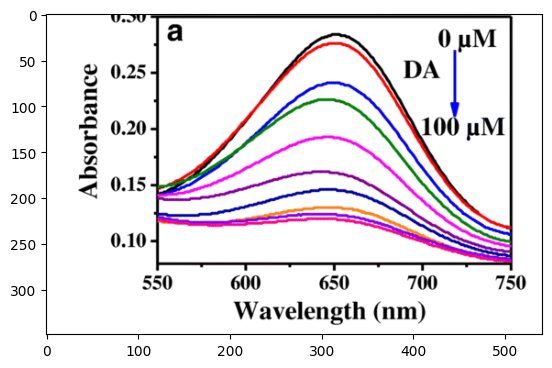

In [165]:
img = mpimg.imread('Majid_colorimetry.png')

# show the image
imgplot = plt.imshow(img)
plt.show()

# first try to isolate lines by colors

In [166]:
# now I want to determine all the unique colors in the image
# first I need to reshape the image into a 2D array
unique_pixels = set()
for row in img:
    for pixel in row:
        unique_pixels.add(tuple(pixel))
print(len(unique_pixels))

1888


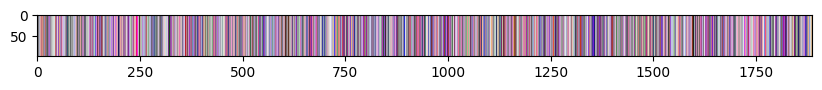

In [167]:
# plot a tile of all the colors
plt.figure(figsize=(10, 10))
plt.imshow([list(unique_pixels)]*100)
plt.show()

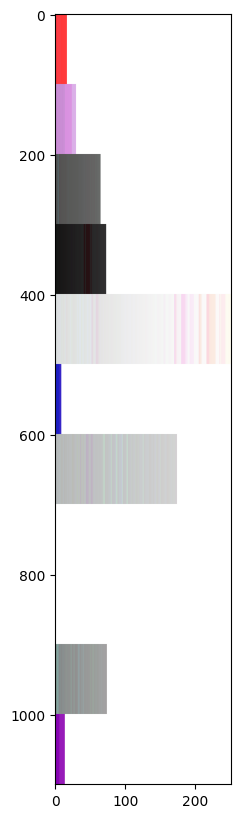

In [168]:
# cluster similar colors together
kmeans = KMeans(n_clusters=11)
kmeans.fit(list(unique_pixels))
colors = kmeans.cluster_centers_
clustered_colors = []
for color in colors:
    # get all the colors in the cluster
    cluster = []
    for pixel in unique_pixels:
        if np.linalg.norm(np.array(pixel) - color) < 0.1:
            cluster.append(pixel)
    clustered_colors.append(sorted(cluster))
# now pad the clusters with white to make them all the same length
max_len = max([len(cluster) for cluster in clustered_colors])
for cluster in clustered_colors:
    cluster.extend([[1, 1, 1, 1]]*(max_len - len(cluster)))
# now duplicate each cluster to make the colors more visible by 100
clustered_colors = np.array(clustered_colors)
clustered_colors = np.repeat(clustered_colors, 100, axis=0)
plt.figure(figsize=(10, 10))
plt.imshow(clustered_colors)
plt.show()    

This will not work due to the overlapping nature of the lines :/

# Try chatGPT approach

In [169]:
colors

array([[0.93603977, 0.26103287, 0.22645679, 1.        ],
       [0.80117648, 0.61458113, 0.89240642, 1.        ],
       [0.32668974, 0.40322954, 0.36175318, 1.        ],
       [0.14046841, 0.14431736, 0.12256718, 1.        ],
       [0.93518639, 0.91620341, 0.92086835, 1.        ],
       [0.12250049, 0.11046399, 0.80399924, 1.        ],
       [0.79305778, 0.76304188, 0.76043457, 1.        ],
       [0.9538639 , 0.1320646 , 0.7081315 , 1.        ],
       [0.61515373, 0.36209151, 0.81578311, 1.        ],
       [0.55213262, 0.60107138, 0.60058623, 1.        ],
       [0.55806103, 0.0495098 , 0.75604577, 1.        ]])

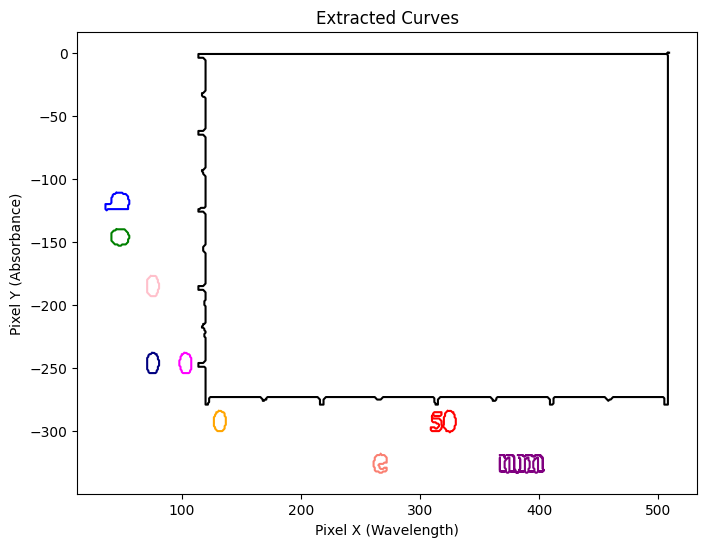

In [170]:

# Load the image
image_path = "Majid_colorimetry.png"
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply edge detection
edges = cv2.Canny(gray, 50, 150)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Sort contours by area to focus on the major curves
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

# Plot extracted contours
plt.figure(figsize=(8, 6))
for contour in contours:
    contour = contour.squeeze()
    if len(contour.shape) == 2:
        plt.plot(contour[:, 0], -contour[:, 1])  # Invert y-axis

plt.xlabel("Pixel X (Wavelength)")
plt.ylabel("Pixel Y (Absorbance)")
plt.title("Extracted Curves")
plt.show()

No just no

# Extract lines using Photoshop

So I can use the Pen tool in photoshop to trace over each line and fill the shape underneath it. For each color I can save a new image. And I can use these 10 manually traced lines to try to obtain the x & y values for each colored line.

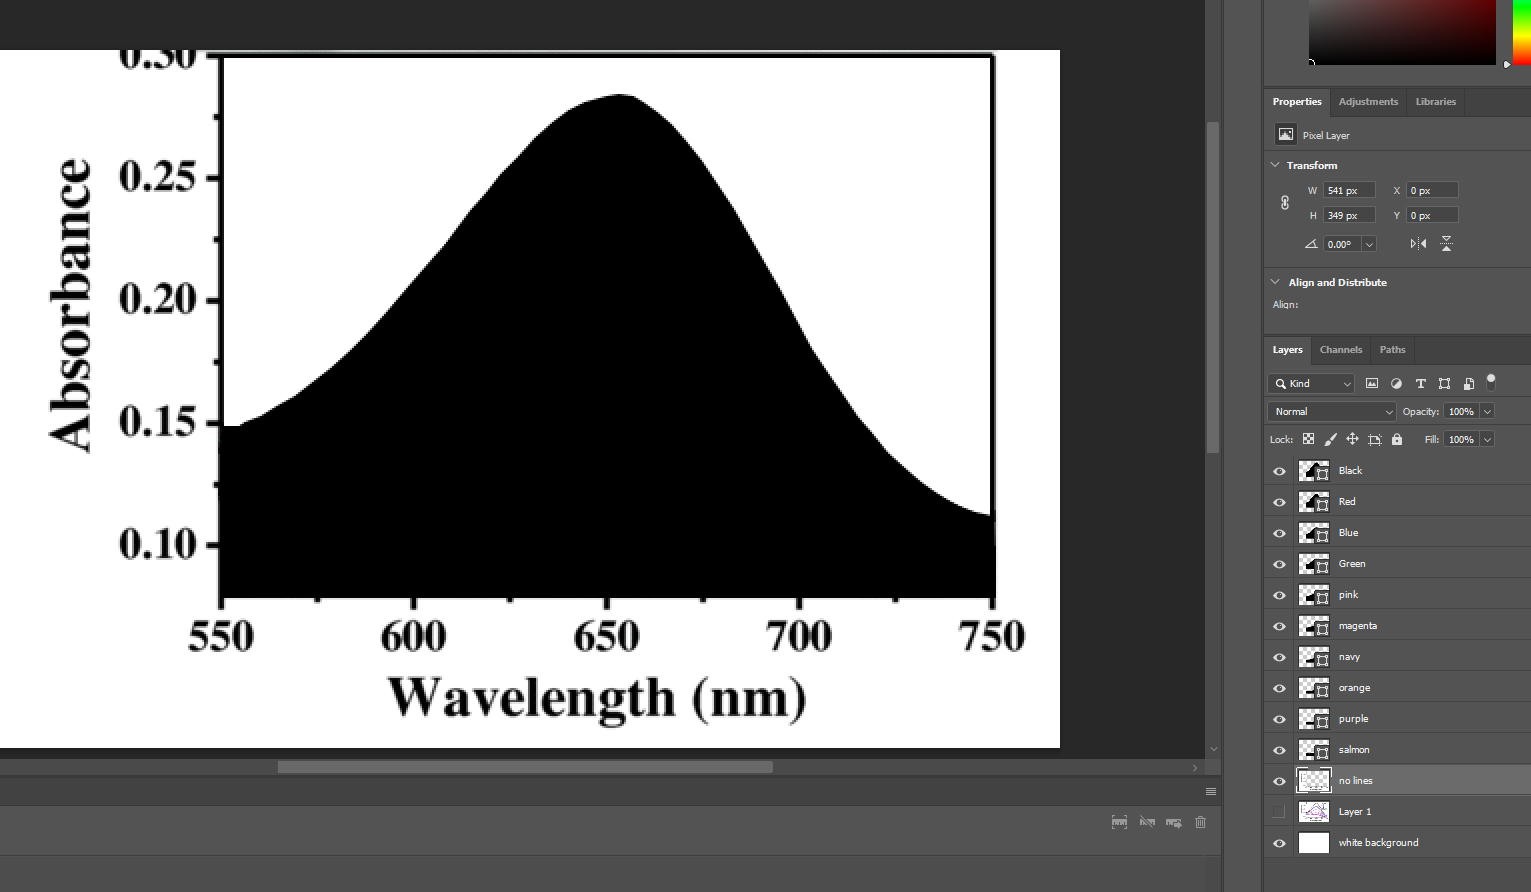

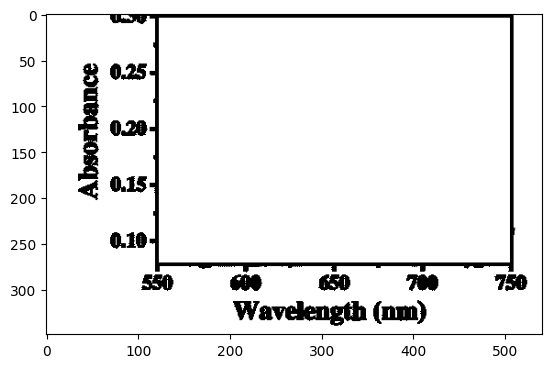

In [171]:
colors=     ["black",  "red",    "blue",   "green",  "pink",   "magenta","navy",   "orange", "purple", "salmon"]
webcolors = ["#000000","#FF0001","#0D0CF9","#017F03","#FF02FF","#8604B4","#0203A6","#FF870C","#9011EE","#FF0381"]
concentrations = [0, 5, 10, 20, 30, 40, 50, 60, 80, 100]

# load the image without any lines
no_line_img = mpimg.imread('traced_PS_lines/Majid_colorimetry_no_lines.png')

# convert the image to grayscale binary mask using otsu thresholding
gray = cv2.cvtColor(no_line_img, cv2.COLOR_BGR2GRAY)
# convert gray to uint8 type
gray = np.uint8(gray)
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# show the image
plt.imshow(binary, cmap='gray')

In [172]:
binary.shape

(349, 541)

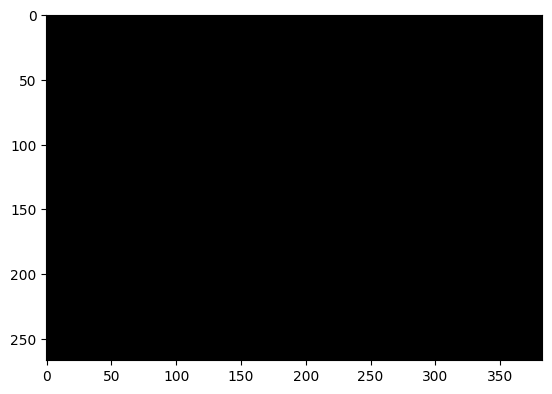

In [173]:
# cropping box for viewing (bottom left corner, top right corner)
cropbox = [4, 271, 123, 506]

# view the cropped image
plt.imshow(binary[cropbox[0]:cropbox[1], cropbox[2]:cropbox[3]], cmap='gray')

In [174]:
np.min(binary[cropbox[0]:cropbox[1], cropbox[2]:cropbox[3]])

np.uint8(255)

Mean Squared Error (for px --> wavelength): 0.0
Mean Squared Error (for px --> absorbance): 0.0


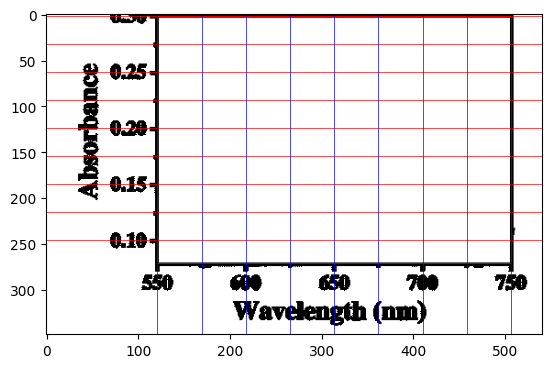

In [175]:
# Create the figure and axes
fig, ax = plt.subplots()
ax.imshow(binary, cmap="gray")  # Display the image

# Define the box parameters (x, y, width, height)
x,y = cropbox[2]-2, cropbox[0]-2.5
width, height = cropbox[3]-cropbox[2]+3, cropbox[1]-cropbox[0]+2.5

# Create a rectangle patch
rect = patches.Rectangle((x, y), width, height, linewidth=0.5, edgecolor='red', facecolor='none')

# Add the rectangle to the axes
ax.add_patch(rect)

nm50_pixels = 48.2
absorbance_p05_pixels = 30.5

absorbance_cutoffs = [0.3,0.275, 0.25, 0.225, 0.2, 0.175, 0.15, 0.125, 0.1]
absorbance_pixel_values = []
# draw red horizontal lines at p05 intervals
i = y
while i < y+height:
    absorbance_pixel_values.append(i)
    plt.axhline(i, color='red', linewidth=0.5)
    i += absorbance_p05_pixels
    
wavelength_cutoffs = [550,575,600,625,650,675,700,725,750]
wavelength_pixel_values = []
# draw blue vertical lines at nm50 intervals
i = x
while i < x+width:
    wavelength_pixel_values.append(i)
    plt.axvline(i, color='blue', linewidth=0.5)
    i += nm50_pixels
# create a linear equation to go from pixel to wavelength
m_w = (wavelength_cutoffs[-1] - wavelength_cutoffs[0])/(wavelength_pixel_values[-1] - wavelength_pixel_values[0])
b_w = wavelength_cutoffs[0] - m_w*wavelength_pixel_values[0]
pixel_to_wavelength = lambda pixel: m_w*pixel + b_w
# check the mse of the linear equation against the rest of the wavelengths
mse = 0
for i, pixel in enumerate(wavelength_pixel_values):
    mse += (pixel_to_wavelength(pixel) - wavelength_cutoffs[i])**2
mse /= len(wavelength_pixel_values)
print(f"Mean Squared Error (for px --> wavelength): {round(mse,3)}")

# create a linear equation to go from pixel to absorbance
m_a = (absorbance_cutoffs[-1] - absorbance_cutoffs[0])/(absorbance_pixel_values[-1] - absorbance_pixel_values[0])
b_a = absorbance_cutoffs[0] - m_a*absorbance_pixel_values[0]
pixel_to_absorbance = lambda pixel: m_a*pixel + b_a
# check the mse of the linear equation against the rest of the abosrbances
mse = 0
for i, pixel in enumerate(absorbance_pixel_values):
    mse += (pixel_to_absorbance(pixel) - absorbance_cutoffs[i])**2
print(f"Mean Squared Error (for px --> absorbance): {round(mse,3)}")

In [176]:
def extract_wave_by_absorb(color):
    fname = f"traced_PS_lines/Majid_colorimetry_{color}.png"
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = np.uint8(gray)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    pixel_results = []
    for wave_px in range(cropbox[2],cropbox[3]):
        absorb_px = 0
        for absorb_px in range(cropbox[1],cropbox[0],-1):
            if binary[absorb_px, wave_px] != 0:
                break
        pixel_results.append((wave_px, absorb_px))
    # now we convert the pixel values to wavelength and absorbance
    results = [(pixel_to_wavelength(wave_px), pixel_to_absorbance(absorb_px)) for wave_px, absorb_px in pixel_results]
    return results

dfs = []
for color,concentration in zip(colors,concentrations):
    df = pd.DataFrame(extract_wave_by_absorb(color), columns=["Wavelength (nm)", "Absorbance"])
    df["Color"] = color
    df["Concentration"] = concentration
    dfs.append(df)
merged_dfs = pd.concat(dfs)
print(merged_dfs.shape)

(3830, 4)


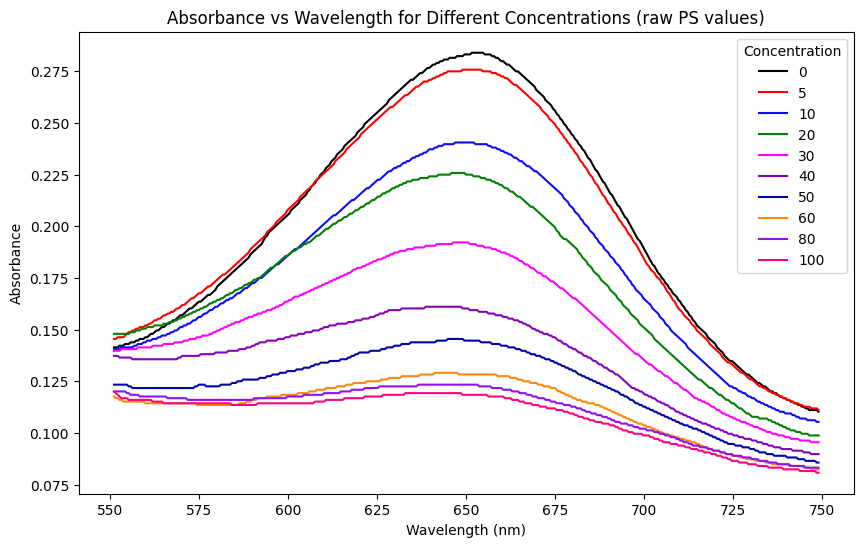

In [177]:
# use seaborn to plot a lineplot of the data
plt.figure(figsize=(10,6))
sns.lineplot(data=merged_dfs, x="Wavelength (nm)", y="Absorbance", hue="Concentration", palette=webcolors)
plt.title("Absorbance vs Wavelength for Different Concentrations (raw PS values)")
plt.show()

In [178]:
smoothed_dfs = []
for color,concentration, webcolor in zip(colors,concentrations, webcolors):
    df = pd.DataFrame(extract_wave_by_absorb(color), columns=["Wavelength (nm)", "Absorbance"])
    df["Color"] = color
    df["Concentration"] = concentration
    # smooth the absorbance values
    df["Smoothed Absorbance"] = lowess(df["Absorbance"], df["Wavelength (nm)"], frac=0.1)[:,1]
    df["webcolor"] = webcolor
    smoothed_dfs.append(df)
smooth_merged_dfs = pd.concat(smoothed_dfs)
print(smooth_merged_dfs.shape)

(3830, 6)


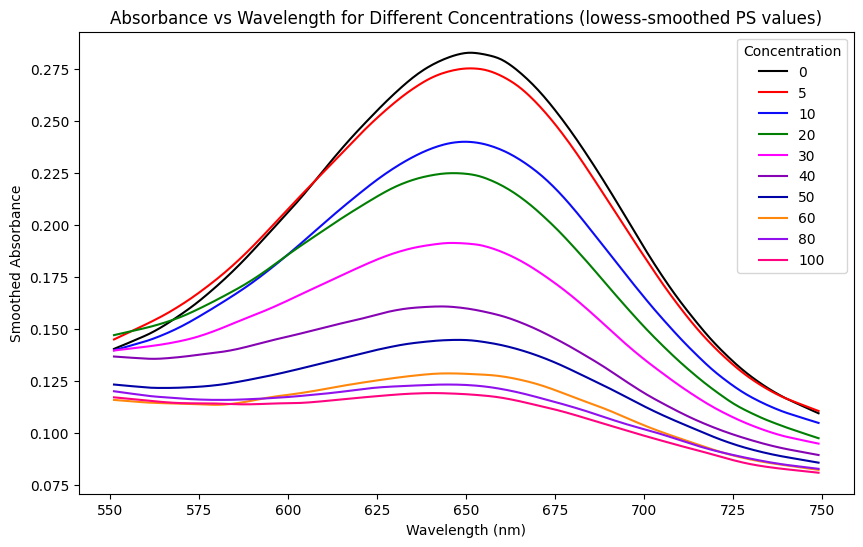

In [179]:
# use seaborn to plot a lineplot of the data
plt.figure(figsize=(10,6))
sns.lineplot(data=smooth_merged_dfs, x="Wavelength (nm)", y="Smoothed Absorbance", hue="Concentration", palette=webcolors)
plt.title("Absorbance vs Wavelength for Different Concentrations (lowess-smoothed PS values)")
plt.show()

In [180]:
# store the data to a csv file
smooth_merged_dfs.to_csv("colorimetry_data_PS_extracted.csv", index=False)